https://setosa.io/ev/image-kernels/

Notes:
http://introtodeeplearning.com/slides/6S191_MIT_DeepLearning_L3.pdf

# Dataset 

https://ceb.nlm.nih.gov/repositories/malaria-datasets/

#### Reduce the burden for microscopists in resource-constrained regions and improve diagnostic accuracy,
* the images were manually annotated by an expert slide reader at the Mahidol-Oxford Tropical Medicine Research Unit in Bangkok, Thailand.

In [1]:
import os
data_dir='data/cell_images/cell_images'
os.listdir(data_dir)

['test', 'train']

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread


In [3]:
test_path = data_dir+'\\test\\'
train_path = data_dir+'\\train\\'

In [4]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [5]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [6]:
os.listdir(train_path+'parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

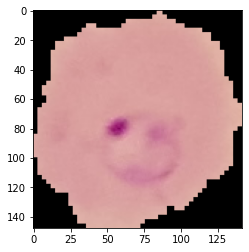

In [7]:
parasite_cell=train_path+'parasitized\\'+'C100P61ThinF_IMG_20150918_144104_cell_162.png'
plt.imshow(imread(parasite_cell))


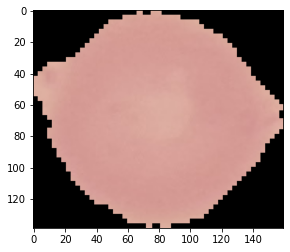

In [8]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [9]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [10]:
len(os.listdir(train_path+'\\uninfected'))

12480

In [11]:
unifected_cell.shape

(139, 160, 3)

In [12]:
# Other options: https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

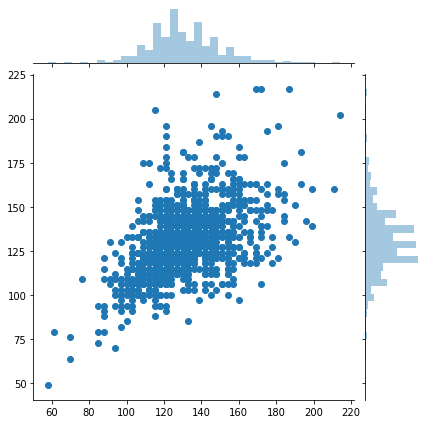

In [13]:
sns.jointplot(dim1,dim2)

In [14]:
np.mean(dim1)

130.92538461538462

In [15]:
np.mean(dim2)

130.75

In [16]:
image_shape = (130,130,3)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
#help(ImageDataGenerator)
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [19]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [20]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Create the Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [22]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [25]:
batch_size = 16

In [26]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [27]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [28]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [30]:
%%time
results = model.fit_generator(train_image_gen,epochs=3,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
1560/1560 [==============================] - 700s 449ms/step - loss: 0.3910 - accuracy: 0.8246 - val_loss: 0.1892 - val_accuracy: 0.9388
Epoch 2/3
1560/1560 [==============================] - 437s 280ms/step - loss: 0.1903 - accuracy: 0.9407 - val_loss: 0.1795 - val_accuracy: 0.9358
Epoch 3/3
1560/1560 [==============================] - 432s 277ms/step - loss: 0.1686 - accuracy: 0.9474 - val_loss: 0.1549 - val_accuracy: 0.9496
Wall time: 26min 14s


In [31]:
from tensorflow.keras.models import load_model
model.save('malaria_model.h5')

In [32]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

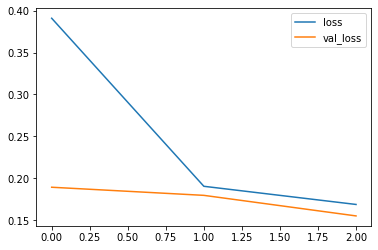

In [33]:
losses[['loss','val_loss']].plot()

In [34]:
model.evaluate_generator(test_image_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.15865930914878845, 0.9469230771064758]

In [35]:
from tensorflow.keras.preprocessing import image

In [36]:
pred_probabilities = model.predict_generator(test_image_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [37]:
pred_probabilities

array([[9.7119808e-04],
       [5.7936904e-05],
       [5.4314733e-04],
       ...,
       [9.6601349e-01],
       [9.7495544e-01],
       [9.1812396e-01]], dtype=float32)

In [38]:
predictions = pred_probabilities > 0.5

In [39]:
from sklearn.metrics import classification_report,confusion_matrix

In [40]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.94      2600
   macro avg       0.95      0.95      0.94      2600
weighted avg       0.95      0.94      0.94      2600



In [41]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1215,   85],
       [  58, 1242]], dtype=int64)

predicting image 

In [42]:
parasite_cell

'data/cell_images/cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [43]:
my_image = image.load_img(parasite_cell,target_size=image_shape)

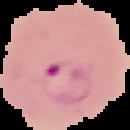

In [44]:
my_image

In [45]:
my_image = image.img_to_array(my_image)

In [46]:
my_image.shape

(130, 130, 3)

In [47]:
my_image = np.expand_dims(my_image, axis=0)

In [48]:
my_image.shape

(1, 130, 130, 3)

In [49]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [50]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [51]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}